In [1]:
import scipy.io
import numpy as np
import pandas as pd
import keras
from keras.preprocessing import image
#from keras.preprocessing.image import Image
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

Using TensorFlow backend.


In [2]:
mat = scipy.io.loadmat('Desktop/wiki_crop/wiki.mat')

In [3]:
instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
  if i == "wiki":
    current_array = mat[i][0][0]
    for j in range(len(current_array)):
      df[columns[j]] = pd.DataFrame(current_array[j][0])

In [4]:
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum))+ timedelta(
    days=int(days)) + timedelta(hours=int(hours)) + timedelta(
    minutes=int(minutes)) + timedelta(seconds=round(
    seconds))- timedelta(days=366)
 
    return exact_date.year

df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [5]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [6]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]
 
#check threshold
df = df[df['face_score'] >= 3]
 
#some records do not have a gender information
df = df[~df['gender'].isna()]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [7]:
df.head()

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [8]:
df = df[:15000]
df.shape

(15000, 5)

In [9]:
target_size = (224, 224)
 
def getImagePixels(image_path):
    img = image.load_img("Desktop/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['full_path'].apply(getImagePixels)

In [10]:
df.head()

,dob,photo_taken,full_path,gender,age,pixels
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,"[92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96...."
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,"[61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30...."
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,"[97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,..."
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,"[190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203..."


In [11]:
classes = 101 #0 to 100
target = df['age'].values
target_classes = to_categorical(target, classes)
 
features = []
for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [12]:
features /= 255.

In [13]:
train_X, test_X, train_Y, test_Y = train_test_split(features, target_classes, test_size = 0.3)
print('Training set: ', train_X.shape, train_Y.shape)
print('Test set: ', test_X.shape, test_Y.shape)

Training set:  (10500, 224, 224, 3) (10500, 101)
Test set:  (4500, 224, 224, 3) (4500, 101)


In [14]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

W0807 13:08:42.410649 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 13:08:42.868781 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 13:08:43.047771 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 13:08:43.121609 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is d

In [15]:
model.load_weights('Desktop/gender_detection/vgg_face_weights.h5')

W0807 13:08:44.932579 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [16]:
for layer in model.layers[:-7]:
    layer.trainable = False
    
base_model_output = Sequential()
base_model_output = Convolution2D(101, (1,1), name="predictions")(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
age_model = Model(inputs = model.input, outputs = base_model_output)

In [17]:
age_model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='age_model.hdf5', monitor = "val_loss", verbose=1,
                               save_best_only=True, mode = 'auto')

scores=[]

W0807 13:09:36.994033 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [18]:
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_X.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_X[ix_train], train_Y[ix_train]
            , epochs=1
            , validation_data=(test_X, test_Y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model("classification_age_model.hdf5")
    
    age_model.save_weights('Desktop/gender_detection/age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("Desktop/gender_detection/age_model_weights.h5")

In [19]:
age_model.evaluate(test_X, test_Y, verbose=1)

4500/4500 [==============================] - 1213s 270ms/step


[3.3043942364586725, 0.06555555558204651]

In [20]:
predictions = age_model.predict(test_X)
output_indexes = np.array([i for i in range(0,101)])
apparent_predictions = np.sum(predictions * output_indexes, axis=1)

In [24]:
mae = 0
for i in range(0,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_Y[i])
    
abs_error = abs(prediction - actual)
mae += abs_error
mae /= apparent_predictions.shape[0]

print('mae: ', mae)
print('instances: ', apparent_predictions.shape[0])

mae:  0.0017777777777777779
instances:  4500


In [25]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224,224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img /= 255.
    return test_img

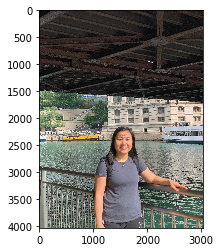

most dominant age class (not apparent age):  29
Age:  30


In [33]:
pic = 'Desktop/test_images/bon.jpg'
prediction = age_model.predict(loadImage(pic))

img = image.load_img(pic)
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))
apparent_age = np.round(np.sum(prediction*output_indexes, axis=1))
print('Age: ',int(apparent_age[0]))

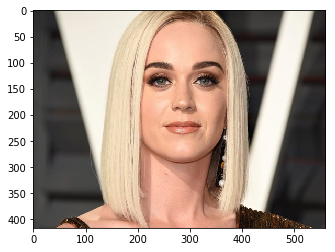

most dominant age class (not apparent age):  36
Age:  36


In [32]:
pic = 'Desktop/test_images/katy.jpg'
prediction = age_model.predict(loadImage(pic))

img = image.load_img(pic)
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))
apparent_age = np.round(np.sum(prediction*output_indexes, axis=1))
print('Age: ',int(apparent_age[0]))

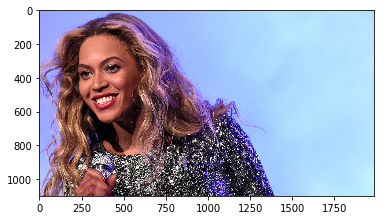

most dominant age class (not apparent age):  22
Age:  25


In [31]:
pic = 'Desktop/test_images/beyonce.jpg'
prediction = age_model.predict(loadImage(pic))

img = image.load_img(pic)
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))
apparent_age = np.round(np.sum(prediction*output_indexes, axis=1))
print('Age: ',int(apparent_age[0]))